In [30]:
import ROOT
import os
import numpy as np

ROOT.gSystem.Load("/users/yewzzang/WCSim_KNO/WCSim_v1.8.0-build/libWCSimRoot.so")


1

In [31]:

class WCSim:
    def __init__(self, tree):
        print("number of entries in the geometry tree: " + str(self.geotree.GetEntries()))
        self.geotree.GetEntry(0)
        self.geo = self.geotree.wcsimrootgeom
        self.num_pmts = self.geo.GetWCNumPMT()
        self.tree = tree
        self.nevent = self.tree.GetEntries()
        print("number of entries in the tree: " + str(self.nevent))
        # Get first event and trigger to prevent segfault when later deleting trigger to prevent memory leak
        self.tree.GetEvent(0)
        self.current_event = 0
        self.event = self.tree.wcsimrootevent
        self.ntrigger = self.event.GetNumberOfEvents()
        self.trigger = self.event.GetTrigger(0)
        self.current_trigger = 0

    def get_event(self, ev):
        # Delete previous triggers to prevent memory leak (only if file does not change)
        triggers = [self.event.GetTrigger(i) for i in range(self.ntrigger)]
        oldfile = self.tree.GetCurrentFile()
        self.tree.GetEvent(ev)
        if self.tree.GetCurrentFile() == oldfile:
            [t.Delete() for t in triggers]
        self.current_event = ev
        self.event = self.tree.wcsimrootevent
        self.ntrigger = self.event.GetNumberOfEvents()

    def get_trigger(self, trig):
        self.trigger = self.event.GetTrigger(trig)
        self.current_trigger = trig
        return self.trigger

    def get_first_trigger(self):
        first_trigger = 0
        first_trigger_time = 9999999.0
        for index in range(self.ntrigger):
            self.get_trigger(index)
            trigger_time = self.trigger.GetHeader().GetDate()
            if trigger_time < first_trigger_time:
                first_trigger_time = trigger_time
                first_trigger = index
        return self.get_trigger(first_trigger)

    def get_truth_info(self):  # deprecated: should now use get_event_info instead, leaving here for use with old files
        self.get_trigger(0)
        tracks = self.trigger.GetTracks()
        energy = []
        position = []
        direction = []
        pid = []
        for i in range(self.trigger.GetNtrack()):
            if tracks[i].GetParenttype() == 0 and tracks[i].GetFlag() == 0 and tracks[i].GetIpnu() in [22, 11, -11, 13,
                                                                                                       -13, 111]:
                pid.append(tracks[i].GetIpnu())
                position.append([tracks[i].GetStart(0), tracks[i].GetStart(1), tracks[i].GetStart(2)])
                direction.append([tracks[i].GetDir(0), tracks[i].GetDir(1), tracks[i].GetDir(2)])
                energy.append(tracks[i].GetE())
        return direction, energy, pid, position

    def get_event_info(self):
        self.get_trigger(0)
        tracks = self.trigger.GetTracks()
        # Primary particles with no parent are the initial simulation
        particles = [t for t in tracks if t.GetFlag() == 0 and t.GetParenttype() == 0]
        # Check there is exactly one particle with no parent:
        if len(particles) == 1:
            # Only one primary, this is the particle being simulated
            return {
                "pid": particles[0].GetIpnu(),
                "position": [particles[0].GetStart(i) for i in range(3)],
                "direction": [particles[0].GetDir(i) for i in range(3)],
                "energy": particles[0].GetE()
            }
        # Particle with flag -1 is the incoming neutrino or 'dummy neutrino' used for gamma
        # WCSim saves the gamma details (except position) in the neutrino track with flag -1
        neutrino = [t for t in tracks if t.GetFlag() == -1]
        # Check for dummy neutrino that actually stores a gamma that converts to e+ / e-
        isConversion = len(particles) == 2 and {p.GetIpnu() for p in particles} == {11, -11}
        if isConversion and len(neutrino) == 1 and neutrino[0].GetIpnu() == 22:
            return {
                "pid": 22,
                "position": [particles[0].GetStart(i) for i in range(3)], # e+ / e- should have same position
                "direction": [neutrino[0].GetDir(i) for i in range(3)],
                "energy": neutrino[0].GetE()
            }
        # Check for dummy neutrino from old gamma simulations that didn't save the gamma info
        if isConversion and len(neutrino) == 1 and neutrino[0].GetIpnu() == 12 and neutrino[0].GetE() < 0.0001:
            # Should be a positron/electron pair from a gamma simulation (temporary hack since no gamma truth saved)
            momentum = [sum(p.GetDir(i) * p.GetP() for p in particles) for i in range(3)]
            norm = np.sqrt(sum(p ** 2 for p in momentum))
            return {
                "pid": 22,
                "position": [particles[0].GetStart(i) for i in range(3)],  # e+ / e- should have same position
                "direction": [p / norm for p in momentum],
                "energy": sum(p.GetE() for p in particles)
            }
        # Otherwise something else is going on... guess info from the primaries
        momentum = [sum(p.GetDir(i) * p.GetP() for p in particles) for i in range(3)]
        norm = np.sqrt(sum(p ** 2 for p in momentum))
        return {
            "pid": 0,  # there's more than one particle so just use pid 0
            "position": [sum(p.GetStart(i) for p in particles)/len(particles) for i in range(3)],  # average position
            "direction": [p / norm for p in momentum],  # direction of sum of momenta
            "energy": sum(p.GetE() for p in particles)  # sum of energies
        }

    def get_digitized_hits(self):
        position = []
        charge = []
        time = []
        pmt = []
        trigger = []
        for t in range(self.ntrigger):
            self.get_trigger(t)
            for hit in self.trigger.GetCherenkovDigiHits():
                pmt_id = hit.GetTubeId() - 1
                position.append([self.geo.GetPMT(pmt_id).GetPosition(j) for j in range(3)])
                charge.append(hit.GetQ())
                time.append(hit.GetT())
                pmt.append(pmt_id)
                trigger.append(t)
        hits = {
            "position": np.asarray(position, dtype=np.float32),
            "charge": np.asarray(charge, dtype=np.float32),
            "time": np.asarray(time, dtype=np.float32),
            "pmt": np.asarray(pmt, dtype=np.int32),
            "trigger": np.asarray(trigger, dtype=np.int32)
        }
        return hits

    def get_true_hits(self):
        position = []
        track = []
        pmt = []
        PE = []
        trigger = []
        for t in range(self.ntrigger):
            self.get_trigger(t)
            for hit in self.trigger.GetCherenkovHits():
                pmt_id = hit.GetTubeID() - 1
                tracks = set()
                for j in range(hit.GetTotalPe(0), hit.GetTotalPe(0)+hit.GetTotalPe(1)):
                    pe = self.trigger.GetCherenkovHitTimes().At(j)
                    tracks.add(pe.GetParentID())
                position.append([self.geo.GetPMT(pmt_id).GetPosition(k) for k in range(3)])
                track.append(tracks.pop() if len(tracks) == 1 else -2)
                pmt.append(pmt_id)
                PE.append(hit.GetTotalPe(1))
                trigger.append(t)
        hits = {
            "position": np.asarray(position, dtype=np.float32),
            "track": np.asarray(track, dtype=np.int32),
            "pmt": np.asarray(pmt, dtype=np.int32),
            "PE": np.asarray(PE, dtype=np.int32),
            "trigger": np.asarray(trigger, dtype=np.int32)
        }
        return hits

    def get_hit_photons(self):
        start_position = []
        end_position = []
        start_time = []
        end_time = []
        track = []
        pmt = []
        trigger = []
        for t in range(self.ntrigger):
            self.get_trigger(t)
            n_photons = self.trigger.GetNcherenkovhittimes()
            trigger.append(np.full(n_photons, t, dtype=np.int32))
            counts = [h.GetTotalPe(1) for h in self.trigger.GetCherenkovHits()]
            hit_pmts = [h.GetTubeID()-1 for h in self.trigger.GetCherenkovHits()]
            pmt.append(np.repeat(hit_pmts, counts))
            end_time.append(np.zeros(n_photons, dtype=np.float32))
            track.append(np.zeros(n_photons, dtype=np.int32))
            start_time.append(np.zeros(n_photons, dtype=np.float32))
            start_position.append(np.zeros((n_photons, 3), dtype=np.float32))
            end_position.append(np.zeros((n_photons, 3), dtype=np.float32))
            photons = self.trigger.GetCherenkovHitTimes()
            end_time[t][:] = [p.GetTruetime() for p in photons]
            track[t][:] = [p.GetParentID() for p in photons]
            try:  # Only works with new tracking branch of WCSim
                start_time[t][:] = [p.GetPhotonStartTime() for p in photons]
                for i in range(3):
                    start_position[t][:,i] = [p.GetPhotonStartPos(i)/10 for p in photons]
                    end_position[t][:,i] = [p.GetPhotonEndPos(i)/10 for p in photons]
            except AttributeError: # leave as zeros if not using tracking branch
                pass
        photons = {
            "start_position": np.concatenate(start_position),
            "end_position": np.concatenate(end_position),
            "start_time": np.concatenate(start_time),
            "end_time": np.concatenate(end_time),
            "track": np.concatenate(track),
            "pmt": np.concatenate(pmt),
            "trigger": np.concatenate(trigger)
        }
        return photons

    def get_tracks(self):
        track_id = []
        pid = []
        start_time = []
        energy = []
        start_position = []
        stop_position = []
        parent = []
        flag = []
        for t in range(self.ntrigger):
            self.get_trigger(t)
            for track in self.trigger.GetTracks():
                track_id.append(track.GetId())
                pid.append(track.GetIpnu())
                start_time.append(track.GetTime())
                energy.append(track.GetE())
                start_position.append([track.GetStart(i) for i in range(3)])
                stop_position.append([track.GetStop(i) for i in range(3)])
                parent.append(track.GetParenttype())
                flag.append(track.GetFlag())
        tracks = {
            "id": np.asarray(track_id, dtype=np.int32),
            "pid": np.asarray(pid, dtype=np.int32),
            "start_time": np.asarray(start_time, dtype=np.float32),
            "energy": np.asarray(energy, dtype=np.float32),
            "start_position": np.asarray(start_position, dtype=np.float32),
            "stop_position": np.asarray(stop_position, dtype=np.float32),
            "parent": np.asarray(parent, dtype=np.int32),
            "flag": np.asarray(flag, dtype=np.int32)
        }
        return tracks

    def get_triggers(self):
        trigger_times = np.empty(self.ntrigger, dtype=np.float32)
        trigger_types = np.empty(self.ntrigger, dtype=np.int32)
        for t in range(self.ntrigger):
            self.get_trigger(t)
            trigger_times[t] = self.trigger.GetHeader().GetDate()
            trig_type = self.trigger.GetTriggerType()
            if trig_type > np.iinfo(np.int32).max:
                trig_type = -1;
            trigger_types[t] = trig_type
        triggers = {
                "time": trigger_times,
                "type": trigger_types
        }
        return triggers


class WCSimFile(WCSim):
    def __init__(self, filename):
        self.file = ROOT.TFile(filename, "read")
        tree = self.file.Get("wcsimT")
        self.geotree = self.file.Get("wcsimGeoT")
        super().__init__(tree)

    def __del__(self):
        self.file.Close()


class WCSimChain(WCSim):
    def __init__(self, filenames):
        self.chain = ROOT.TChain("wcsimT")
        for file in filenames:
            self.chain.Add(file)
        self.file = self.GetFile()
        self.geotree = self.file.Get("wcsimGeoT")
        super().__init__(self.chain)

def get_label(infile):
    if "_gamma" in infile:
        label = 0
    elif "_e" in infile:
        label = 1
    elif "_mu" in infile:
        label = 2
    elif "_pi0" in infile:
        label = 3
    else:
        print("Unknown input file particle type")
        raise SystemExit
    return label

In [32]:
import numpy as np

row_remap=np.flip(np.arange(16))

"""
The index starts at 1 and counts up continuously with no gaps
Each 19 consecutive PMTs belong to one mPMT module, so (index-1)/19 is the module number.
The index%19 gives the position in the module: 1-12 is the outer ring, 13-18 is inner ring, 0 is the centre PMT
The modules are then ordered as follows:
It starts by going round the second highest ring around the barrel, then the third highest ring, fourth highest
ring, all the way down to the lowest ring (i.e. skips the highest ring).
Then does the bottom end-cap, row by row (the first row has 6 modules, the second row has 8, then 10, 10, 10,
10, 10, 10, 8, 6).
Then the highest ring around the barrel that was skipped before, then the top end-cap, row by row.
I'm not sure why it has this somewhat strange order...
WTF: actually it is: 2, 6, 8 10, 10, 12 and down again in the caps
"""

def module_index(pmt_index):
    """Returns the module number given the 0-indexed pmt number"""
    return pmt_index//19

def pmt_in_module_id(pmt_index):
    """Returns the pmt number within a 
    module given the 0-indexed pmt number"""
    return pmt_index%19

def is_barrel(module_index):
    """Returns True if module is in the Barrel"""
    return ( (module_index<600) | ((module_index>=696)&(module_index<736)) )

def is_bottom(module_index):
    """Returns True if module is in the bottom cap"""
    return ( (module_index>=600)&(module_index<696) )

def is_top(module_index):
    """Returns True if module is in the top cap"""
    return ( (module_index>=736)&(module_index<832) )

def rearrange_barrel_indices(module_index):
    """rearrange indices to have consecutive module 
    indexing starting with top row in the barrel"""

    #check if there are non-barrel indices here
    is_not_barrel= ~is_barrel(module_index)
    any_not_barrel=np.bitwise_or.reduce(is_not_barrel)
    if any_not_barrel:
        raise ValueError('Passed a non-barrel PMT for geometry processing')
    
    rearranged_module_index=np.zeros_like(module_index)
    barrel_bulk_indices=np.where(module_index<600)
    #print "barrel_bulk_indices"
    #print barrel_bulk_indices
    barrel_top_row_indices=np.where( ((module_index>=696)&(module_index<736)) )
    #print "barrel_top_row_indices"
    #print barrel_top_row_indices
    rearranged_module_index[barrel_bulk_indices]=module_index[barrel_bulk_indices]+40
    rearranged_module_index[barrel_top_row_indices]=module_index[barrel_top_row_indices]-696
    #print "rearranged_module_index"
    #print rearranged_module_index
    return rearranged_module_index


def row_col_rearranged(rearranged_barrel_index):
    """return row and column index based on the rearranged module indices"""
    #print "rearanged_barrel_index: "
    #print rearranged_barrel_index
    #print "rearanged_barrel_index//40: "
    #print rearranged_barrel_index//40
    
    row=row_remap[rearranged_barrel_index//40]
    col=rearranged_barrel_index%40
    return row, col

def row_col(module_index):
    """return row and column from a raw module index"""
    #print "module_index:"
    #print module_index
    return row_col_rearranged(rearrange_barrel_indices(module_index))

In [33]:
input_file = "/store/cpnr/users/yewzzang/KNO_mu_500/root/mu_500MeV_1325.root"
# input_file = "/store/cpnr/users/yewzzang/KNO_cla_gamma/gamma_300Mev_10.root"

In [34]:
wcsim = WCSimFile(input_file)

number of entries in the geometry tree: 1
number of entries in the tree: 2000


In [35]:
geo = wcsim.geo # Gets the geotree
num_pmts = geo.GetWCNumPMT()
print(num_pmts)

30912


In [36]:
position = [0,0,0]
orientation = [0,0,0]
for i in range(num_pmts):
    pmt = geo.GetPMT(i) # This is based on 0 based indexing
    pmt_id = pmt.GetTubeNo() # This literally will just return i + 1
    for j in range(3):
        position[j] = pmt.GetPosition(j) # Not too sure what is x,y,z
        orientation[j] = pmt.GetOrientation(j) # not too sure how direction is stored
    print(i, position, orientation)

0 [4106.4609375, 50.6717529296875, -3717.979248046875] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
1 [4106.4609375, 50.6717529296875, -3617.493408203125] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
2 [4106.4609375, 50.6717529296875, -3517.00732421875] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
3 [4101.525390625, 151.1397705078125, -3717.979248046875] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
4 [4101.525390625, 151.1397705078125, -3617.493408203125] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
5 [4101.525390625, 151.1397705078125, -3517.00732421875] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
6 [4096.58984375, 251.60780334472656, -3717.979248046875] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
7 [4096.58984375, 251.60780334472656, -3617.493408203125] [-0.9987954497337341, -0.049067676067352295, 6.123234262925839e-17]
8 [

In [37]:
num_of_events = wcsim.nevent
print(num_of_events)

2000


In [38]:
wcsim.get_event(0) # Note that this doesn't actually set the event. It just changes the internal state of wcsim
trigger = wcsim.get_first_trigger() # We also use first trigger dunno why
num_hits = trigger.GetNcherenkovdigihits() 
print(num_hits)

1599


In [39]:
direction, energy, pid, position = wcsim.get_truth_info()
print("The particle is ", pid) # I don't understand why there is 2 particles. (positron and electron??!)
print("The initial energy of the particle is ", energy) # corresponding to each particle 
print("The direction of the particle is ", direction)
print("The position of the particle is ", position) # I guess one position per particle

The particle is  [11, 13]
The initial energy of the particle is  [7.242073059082031, 605.6583862304688]
The direction of the particle is  [[0.0704118087887764, 0.7206616997718811, 0.689702033996582], [-0.23464363813400269, 0.7738316655158997, 0.588325560092926]]
The position of the particle is  [[0.0, 0.0, 0.0], [-1763.994384765625, 1101.047119140625, 1488.9217529296875]]


In [40]:
for i in range(num_hits):
    hit = trigger.GetCherenkovDigiHits().At(i)
    
    hit_q = hit.GetQ() # I think q is the energy
    hit_t = hit.GetT() # I think t is the time of the hit
    hit_pmt_id = hit.GetTubeId() - 1 # Need to correspond this to geo.GetPmt()
                                        # GetTubeId() returns 1 based indexing
    
    print(hit_pmt_id, hit_q, hit_t)

8878 1.0362703800201416 613.5999755859375
24551 1.5420833826065063 1228.4000244140625
16169 1.0045734643936157 1613.199951171875
13141 1.3246477842330933 565.6000366210938
14429 1.3261820077896118 562.0
9811 0.5597139000892639 570.4000244140625
25591 0.8145777583122253 577.2000122070312
4055 1.2498588562011719 574.7999877929688
19985 1.0666770935058594 580.4000244140625
23352 0.7760889530181885 582.0
18674 1.0107935667037964 582.4000244140625
24701 1.0443886518478394 586.4000244140625
21901 0.7932406067848206 594.4000244140625
17820 1.0063165426254272 592.4000244140625
20011 1.529863715171814 596.7999877929688
11382 1.050113558769226 598.7999877929688
3245 1.6027568578720093 599.5999755859375
27358 1.6407533884048462 604.0
2918 1.007853627204895 601.5999755859375
24215 1.489233136177063 605.5999755859375
10544 1.7941162586212158 607.5999755859375
23246 1.2439919710159302 620.0
19194 1.2951964139938354 625.2000122070312
5805 1.3400107622146606 627.2000122070312
14452 1.564727783203125 6

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

%matplotlib inline

In [42]:
def isTopRing(mPMT_index):
    return (mPMT_index>=696)&(mPMT_index<736)

def isBotRing(mPMT_index):
    return (mPMT_index>=560)&(mPMT_index<600)

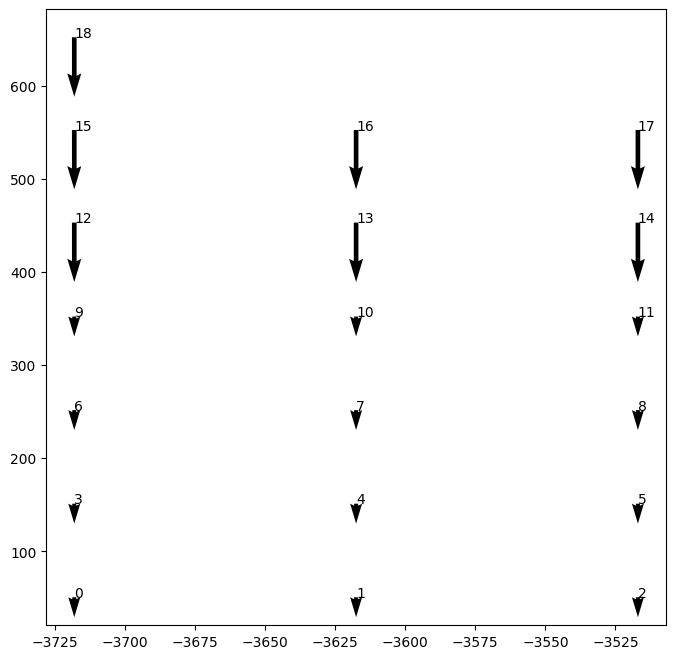

In [43]:
x = []
y = []
z = []

dx = []
dy = []
dz = []
indicies = [] # Note this will be 1 off from PMT number
for PMT_index in range(0, 0+19):
    PMT = geo.GetPMT(PMT_index)

    x.append(PMT.GetPosition(0))
    y.append(PMT.GetPosition(1))
    z.append(PMT.GetPosition(2))

    dx.append(PMT.GetOrientation(0))
    dy.append(PMT.GetOrientation(1))
    dz.append(PMT.GetOrientation(2))

    indicies.append(PMT_index)

plt.figure(figsize=(8,8))
ax = plt.gca()

plt.quiver(z, y, dz, dy)
for i, index in enumerate(indicies):
     ax.annotate(index, (z[i], y[i]))